In [1]:
import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.regular as regular
import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.pbfg as pbfg
import mlgrad.gd as gd

import sklearn.linear_model as linear_model
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.decomposition as decomposition

import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper', 'seaborn-white'])
plt.matplotlib.rcParams['figure.dpi'] = 100
plt.matplotlib.rcParams['savefig.dpi'] = 100


In [2]:
def make_dataset(N, p=1.0):
    xrange = np.linspace(-4., 4., N)
    yrange = 3 * xrange
    M = int(N*p)
    xnoise = 8*np.random.random(M)-4
    ynoise = 0.5*xnoise + 10*np.random.random(M)-5
    X = np.hstack((xrange, xnoise))
    Y = np.hstack((yrange, ynoise))
    return Y, X

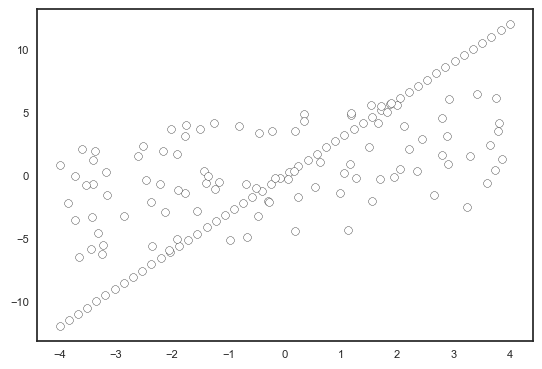

In [3]:
Y, X = make_dataset(50, 2.0)
plt.scatter(X, Y, c='w', edgecolors='k',)
plt.show()

In [4]:
line2 = model.LinearModel([0.,0.5])

huber_func = func.Huber(1.0)
gd2_alg = gd.FG(line2, loss.Loss(huber_func), h=1.0, tol=1.0e-6)
gd2_alg.fit(X.reshape(-1,1), Y)
print(gd2_alg.K, line2.param.base)

21 [ 0.41539913  1.56799862]


In [5]:
line = model.LinearModel([0, 0.33])

d = {"u":[],"param":[], "K":[], "Ka":[]}
def callback(alg):
    d["u"].append(avr_func.u)
    d["K"].append(gd_alg.K)
    d["Ka"].append(avr_func.K)
    d["param"].append(line.param.base.copy())

loss_func = loss.Loss(func.Square())
dsm_func = func.Quantile_AlphaLog(0.01, 0.34)

avr_func = avragg.Average_FG(dsm_func, h=0.1, tol=1.0e-5)
avr_func.use_deriv_averager(avragg.AdaM1(0.999))

gd_alg = gd.FG(line, loss_func, h=0.01, tol=1.0e-5)
gd_alg.use_gradient_averager(gd.AdaM1(0.999))

fg = pbfg.PbFG(avr_func, gd_alg, tol=1.0e-5)
fg.callback = callback
fg.fit(X.reshape(-1,1), Y)

print(fg.K, gd_alg.K, avr_func.K, line.param.base)

124 63 13 [ 0.01997822  2.99126029]


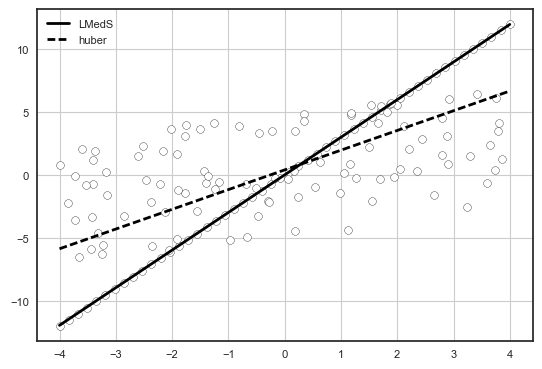

In [6]:
plt.scatter(X, Y, c='w', edgecolors='k',)
plt.plot([-4.,4.], line.evaluate_all([-4.,4.]), c='k', linewidth=2., label='LMedS')
plt.plot([-4.,4.], line2.evaluate_all([-4.,4.]), c='k', linewidth=2., linestyle='--', label='huber')
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper left')
plt.show()

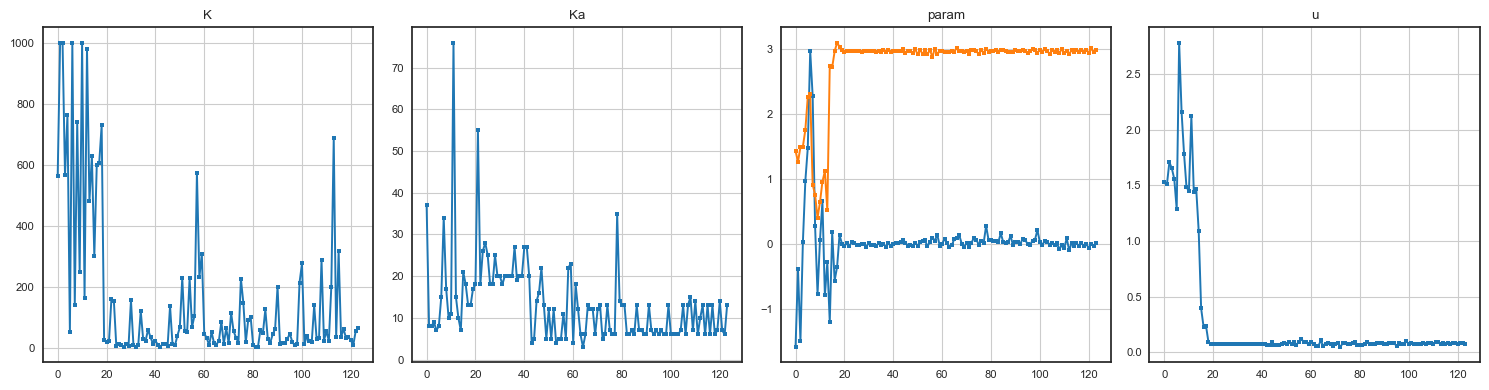

In [7]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        #plt.plot(k_range[-1:], np.abs(u_seq[-1:]), marker='s', markersize=8)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
plot_log(d)